In [4]:
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
import sys
sys.path.append('../src/fnc')

import LMPC
import SysModel
from Track import Map
import Utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [50]:
trackMap = Map(0.8) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 500

In [51]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    x = np.random.uniform(size=[n]) * np.array([3, 1, 1, 1, trackMap.TrackLength, 2*0.8]) + np.array([0, 0, 0, 0, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


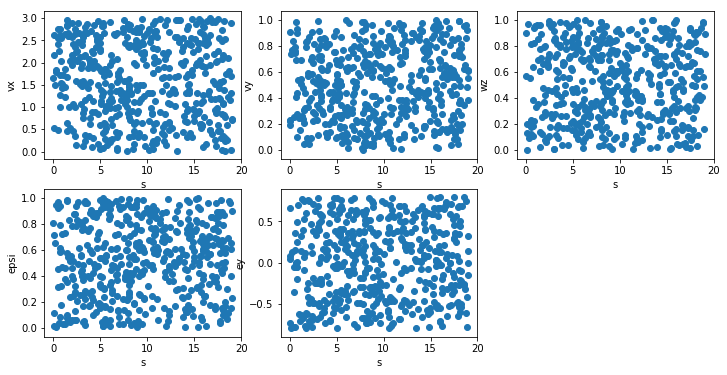

In [52]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [53]:
nc_list = [3, 5, 10]
best_clustering = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n)


===================== Fitting model with Nc= 3 ====================
assigning datapoints to clusters
updating models
centroid movement 3.83160518166
assigning datapoints to clusters
updating models
centroid movement 0.422478081241
assigning datapoints to clusters
updating models
centroid movement 0.185209456734
assigning datapoints to clusters
updating models
centroid movement 0.237034064834
assigning datapoints to clusters
updating models
centroid movement 0.197462290114
assigning datapoints to clusters
updating models
centroid movement 0.101323172173
assigning datapoints to clusters
updating models
centroid movement 0.140076320148
assigning datapoints to clusters
updating models
centroid movement 0.0693882372906
assigning datapoints to clusters
updating models
centroid movement 0.0
done
avg train error: 0.0255376374223
avg test error: 0.0389576517381
===================== Fitting model with Nc= 5 ====================
assigning datapoints to clusters
updating models
centroid movement 

In [54]:
best_clustering.Nc

10

In [57]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 72000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 4570, constraints m = 9000
Cones:	linear vars: 9000
Setup time: 3.31e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.65e+00  5.58e+00  9.79e-01 -1.96e+01  2.71e+01  5.84e-15  3.49e-02 
   100| 1.77e-01  3.05e-01  1.89e-02  7.58e+00  7.89e+00  1.50e-15  4.83e-01 
   200| 1.39e-01  1.69e-01  3.40e-02  3.14e+00  3.39e+00  1.98e-15  9.79e-01 
   300| 7.64e-02  8.77e-02  2.93e-02  1.24e+00  1.34e+00 

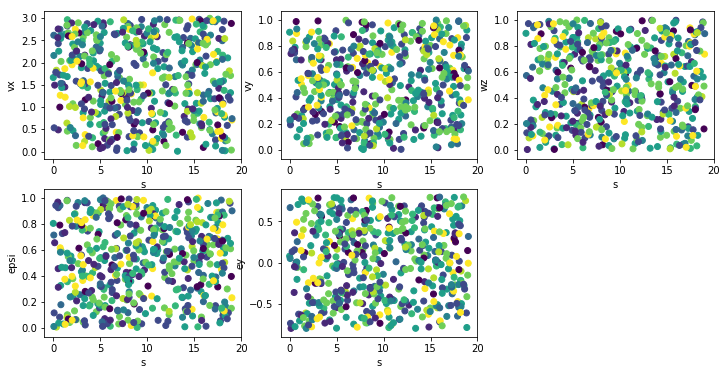

In [58]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [59]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_10', labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=zs, ys=ys)

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]
